# Laboratorio #8
## Defensa contra el ataque de envenenamiento
- Marco Ramírez
- Estuardo Hernández

## Preparación de la data para el ataque

In [50]:
# Importamos las librerías a utilizar
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from art.estimators.classification import KerasClassifier # No soporta TF 2
tf.compat.v1.disable_eager_execution()
import pandas as pd
import os
from PIL import Image
from keras.utils import image_dataset_from_directory
from art.attacks.extraction import CopycatCNN
from keras import models, layers
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns
from art.defences.postprocessor import ReverseSigmoid

In [51]:
# Utilizamos las 939 imágenes que separamos para el ataque y creamos un dataframe
dir = "./random_imgs/"
imgs_location = './selected/selected'
data = []
for family in os.scandir(dir):
    if family.is_dir:
        for malware in os.scandir(family):
            width, height = Image.open(malware.path).size
            data.append({ 
                "name": malware.name, 
                "path": malware.path,
                "family": family.name,
                "width": width,
                "height": height,
            })
    

df = pd.DataFrame(data, columns=["name", "path", "family", "width", "height"])
df

,name,path,family,width,height
0,000e30a0819ac7ed931d629ce2ef8948.png,./random_imgs/Adialer.C\000e30a0819ac7ed931d62...,Adialer.C,512,409
1,002f06eff1d222560939be72583d6ae9.png,./random_imgs/Adialer.C\002f06eff1d222560939be...,Adialer.C,512,410
2,0046a83d932a3d431eb21a99b46d6af7.png,./random_imgs/Adialer.C\0046a83d932a3d431eb21a...,Adialer.C,512,409
3,01aa7da4d2709a0ceb69771fc837730c.png,./random_imgs/Adialer.C\01aa7da4d2709a0ceb6977...,Adialer.C,512,409
4,01fac2472eab8532d8f5951ff48637d4.png,./random_imgs/Adialer.C\01fac2472eab8532d8f595...,Adialer.C,512,410
...,...,...,...,...,...
934,07df93176f9eb61f1cb7a885d8829fbb.png,./random_imgs/Yuner.A\07df93176f9eb61f1cb7a885...,Yuner.A,768,683
935,08004d4675258aa177d07235eb0375ed.png,./random_imgs/Yuner.A\08004d4675258aa177d07235...,Yuner.A,768,683
936,0823d0fa9e21cee43174ecd9931846d4.png,./random_imgs/Yuner.A\0823d0fa9e21cee43174ecd9...,Yuner.A,768,683
937,0860ed8a40ea6a2acd816426da6ed1a9.png,./random_imgs/Yuner.A\0860ed8a40ea6a2acd816426...,Yuner.A,768,683


In [52]:
# Agrupamos por familia
def get_stratified_sample(df, amount, seed=12345):
    return df.groupby('family', as_index=False, group_keys=False) \
                .apply(lambda s: s.sample(min(amount, len(s)), random_state=seed))
df2 = get_stratified_sample(df, 100)

In [53]:
# Dividimos en entrenamiento y pruebas
test_data1 = image_dataset_from_directory(
    imgs_location,
    image_size=(80, 80),
    shuffle=True,
    seed=191919,
)

test_labels1 = []
test_images1 = []
for image, label in tfds.as_numpy(test_data1):
    test_labels1.extend(label)
    test_images1.extend(image)

test_images1 = np.array(test_images1)
test_labels1 = np.array(test_labels1)

Found 672 files belonging to 25 classes.


## Ataque de envenenamiento

In [54]:
# Cargamos el modelo
vulnerable_model = tf.keras.models.load_model("malware-class.h5")

In [55]:
# Utilizamos el KerasClassifier
clasificador = KerasClassifier(
    model=vulnerable_model,
)

In [56]:
# Importamos las librerias a utilizar
from art.attacks.evasion import FastGradientMethod

# Ataque FGSM al clasificador con perturbación de 0.9
attack_fgsm = FastGradientMethod(
    estimator=clasificador, 
    eps=0.9,
)

In [57]:
# Generamos ejemplos adversarios
test_images_mal = attack_fgsm.generate(x=np.array(test_images1))

c:\Users\xavih\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

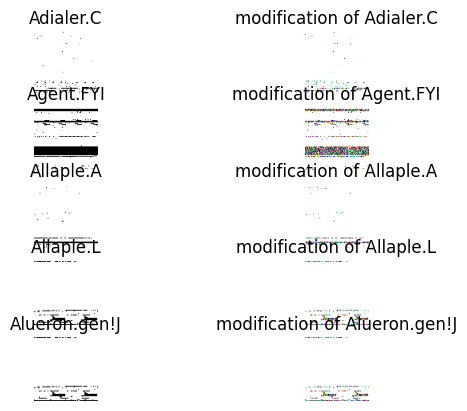

In [58]:
# Comparar las imagenes originales con las alteradas
for i in range(5):
    original = test_images1[i]
    modified = test_images_mal[i]
    label = test_data1.class_names[i]

    plt.subplot(5, 2, i*2+1)
    plt.imshow(original)
    plt.title(label)
    plt.axis('off')

    plt.subplot(5, 2, i*2+2)
    plt.imshow(modified)
    plt.title(f"modification of {label}")
    plt.axis('off')
plt.show()

## Aplicamos la defensa al modelo

In [59]:
# Valores min y max
min_val = np.amin(test_images_mal)
max_val = np.amax(test_images_mal)
# Normalizacion
normalized_images = (test_images_mal - min_val) / (max_val - min_val)

In [60]:
# Dividir en entrenamiento y prueba
test_data2 = image_dataset_from_directory(
    imgs_location,
    image_size=(80, 80),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=191919,
)


training_data2 = image_dataset_from_directory(
    imgs_location,
    image_size=(80, 80),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=191919,
)

Found 672 files belonging to 25 classes.
Using 134 files for validation.
Found 672 files belonging to 25 classes.
Using 538 files for training.


In [61]:
model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(80, 80, 3)),     # Normalizamos
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(test_data2.class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [62]:
epochs=10
metrics = model.fit(training_data2, validation_data=test_data2, epochs=epochs)

Train on 17 steps, validate on 5 steps
Epoch 1/10
17/17 [==============================] - ETA: 0s - batch: 8.0000 - size: 1.0000 - loss: 2.8091 - accuracy: 0.2565

c:\Users\xavih\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


17/17 [==============================] - 17s 624ms/step - batch: 8.0000 - size: 1.0000 - loss: 2.8091 - accuracy: 0.2565 - val_loss: 2.3457 - val_accuracy: 0.3881
Epoch 2/10
17/17 [==============================] - 3s 166ms/step - batch: 8.0000 - size: 1.0000 - loss: 1.9950 - accuracy: 0.4126 - val_loss: 1.3539 - val_accuracy: 0.6119
Epoch 3/10
17/17 [==============================] - 3s 158ms/step - batch: 8.0000 - size: 1.0000 - loss: 1.1326 - accuracy: 0.6617 - val_loss: 0.6941 - val_accuracy: 0.7463
Epoch 4/10
17/17 [==============================] - 3s 155ms/step - batch: 8.0000 - size: 1.0000 - loss: 0.6056 - accuracy: 0.8178 - val_loss: 0.4936 - val_accuracy: 0.8582
Epoch 5/10
17/17 [==============================] - 3s 146ms/step - batch: 8.0000 - size: 1.0000 - loss: 0.3993 - accuracy: 0.8755 - val_loss: 0.4487 - val_accuracy: 0.8881
Epoch 6/10
17/17 [==============================] - 3s 151ms/step - batch: 8.0000 - size: 1.0000 - loss: 0.3468 - accuracy: 0.8941 - val_loss: 0.

### Coparación entre el modelo robado sin defender vs el modelo robado con defensa implementada

In [63]:
# Predicción de las etiquetas de las imagenes del modelo sin defender
alt_probabilities = clasificador.predict(test_images_mal)
alt_probabilities = np.array(alt_probabilities)
alt_predicted_labels = np.argmax(alt_probabilities, axis=-1)

In [64]:
# Predicción de las etiquetas de las imagenes del modelo defendido
probabilities_def = []
true_labels_def = []

test_images2, test_labels2 = zip(*tfds.as_numpy(test_data2))
for img_batch, label_batch in zip(test_images2, test_labels2):
    probability_batch = model.predict(img_batch)
    probabilities_def.extend(probability_batch)
    true_labels_def.extend(label_batch)

probabilities_def = np.array(probabilities_def)
true_labels_def = np.array(true_labels_def)

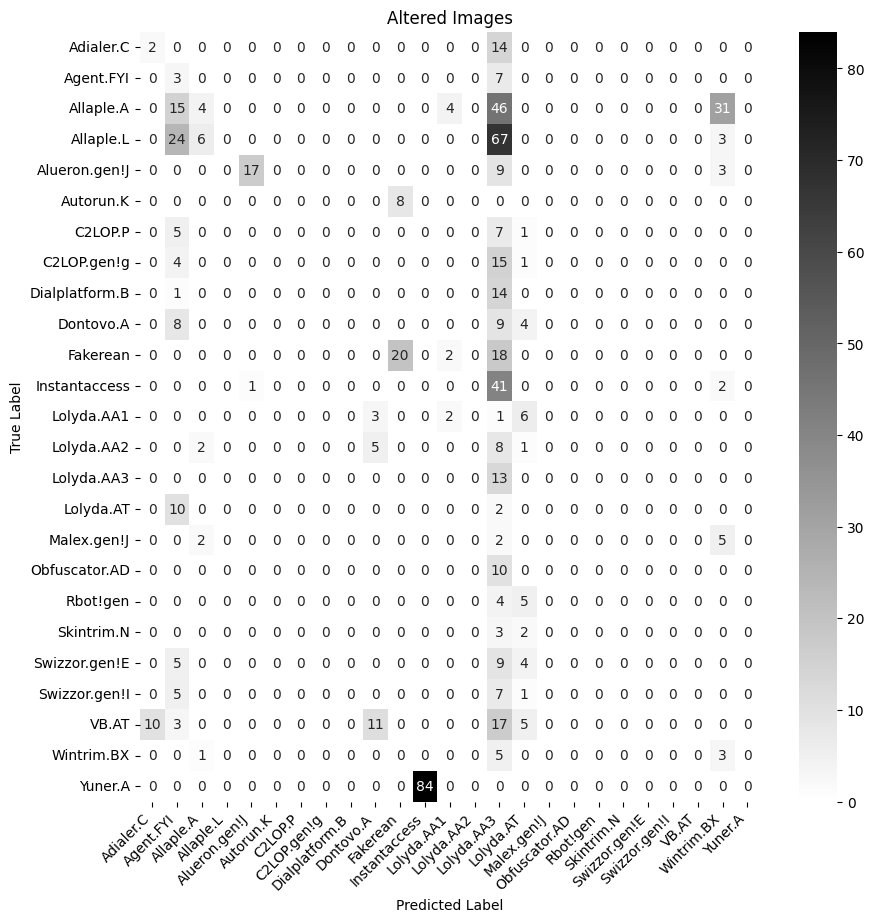

In [65]:
# Matriz de confusion de prediccion del modelo sin defender
cm = confusion_matrix(test_labels1, alt_predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='binary', cbar=True, xticklabels=test_data1.class_names, yticklabels=test_data1.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Altered Images')
plt.show()

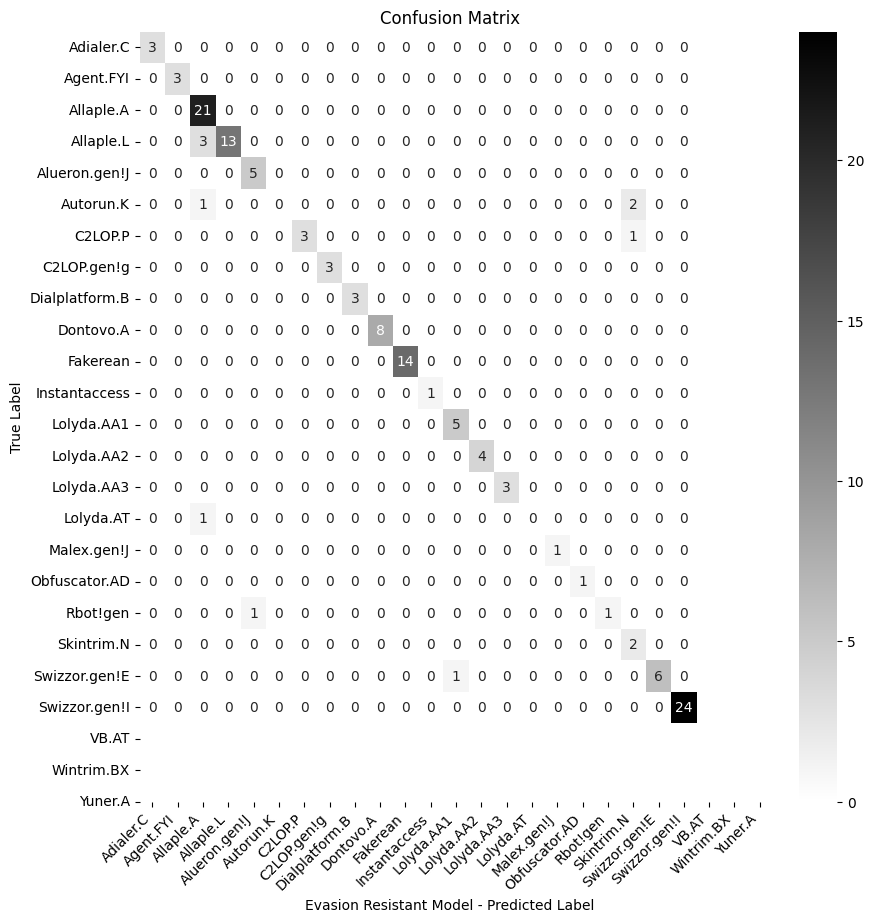

In [66]:
# Matriz de confusion de prediccion del modelo sin defender
predicted_labels = np.argmax(probabilities_def, axis=-1)
cm = confusion_matrix(true_labels_def, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='binary', cbar=True, xticklabels=test_data2.class_names, yticklabels=test_data2.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Evasion Resistant Model - Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Es evidente que el modelo defendido clasificó mucho mejor las imágenes a pesar de que se le pasaron imágenes alteradas. Ahora el primero sin defensa, si se logró hacer que se cofundiera y por ende clasificar mal las imágenes. Entonces, se concluye que la defensa implementada tuvo un impacto considerable a la hora de enfrentarse a ataques de envenenamiento.